In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import math
from sympy import *
import itertools as it
import pickle
import time
from sklearn.decomposition import PCA

In [180]:
class nnet:
    def __init__(self,init_X,init_y,test_data = (),hidden = 8):
        #np.random.seed(0)
        self.m = hidden   #number of hidden neurons
        self.n = init_X.shape[0] #number of samples
        self.beta = 0.2    #regularization parameter
        self.lr = 0.1
        self.max_iters = 200
        
        self.X_all = init_X
        self.y_all = init_y
        self.test_data = len(test_data) != 0
        
        if self.test_data:
            self.X_test,self.y_test = test_data
        
        self.X = init_X
        self.y = init_y
                
        self.w1 = np.random.randn(self.X.shape[1],self.m) * 0.5
        #self.b1 = np.ones(1,m)
        self.w2 = np.random.randn(self.m,self.y.shape[1]) * 0.5
        #self.b2 = np.ones(1,self.Y.shape[1])
        
        self.loss_arr = []
        self.test_acc_arr = []
        self.trial_arr = []
        self.trial_acc_arr = []
    
    def reset(self):
        self.w1 = np.random.randn(self.X.shape[1],self.m) * 0.5
        self.w2 = np.random.randn(self.m,self.y.shape[1]) * 0.5
        self.trial_arr.append(self.loss_arr)
        self.loss_arr = []
           
        if self.test_data:
            self.trial_acc_arr.append(self.test_acc_arr)
            self.test_acc_arr = []
        
    def ReLU(self,x):
        return np.maximum(0,x)
    
    def d_ReLU(self,x):
        return np.nan_to_num(np.maximum(0,x)/x,nan = 0)
    
    def f(self,y_pred):
        return 0.5*np.linalg.norm(y_pred-self.y)**2 + self.beta/2 * np.sum(np.linalg.norm(self.w1,axis = 0)**2 + self.w2**2)
    
    def d_f(self):
        d_w1_left = self.X.T @ (((self.ReLU(self.X @ self.w1) @ self.w2 - self.y) @ self.w2.T) \
                             * self.d_ReLU(self.X @ self.w1))
        d_w1_right = self.beta * self.w1
        d_w1 = d_w1_left + d_w1_right
        
        d_w2_left = self.ReLU(self.X @ self.w1).T @ ((self.ReLU(self.X @ self.w1) @ self.w2 - self.y)) 
        d_w2_right = self.beta * self.w2
        d_w2 = d_w2_left + d_w2_right
        
        #print(d_w2_left,d_w2_right)
        return d_w1,d_w2
        
        
    def forward(self,use_all = False):
        if use_all:
            X = self.X_all
        else:
            X = self.X
        
        layer_1 = X @ self.w1 #+ self.b1
        relu = self.ReLU(layer_1)
        layer_2 = relu @ self.w2 #+ self.b2
        #print(layer_2)
        
        y_pred = layer_2
        loss = self.f(y_pred)
        return y_pred, loss
        
    def backward(self):
        d_w1, d_w2 = self.d_f()

        self.w1 -= self.lr * d_w1 
        self.w2 -= self.lr * d_w2
        
    def gradient_descent(self):
        for i in range(self.max_iters):
            ind = np.random.randint(0,self.n)
            self.X = np.array([self.X_all[ind]])
            self.y = np.array([self.y_all[ind]])
            #print(self.X,self.y)
            y_pred,loss = self.forward()
            self.backward()
            self.loss_arr.append(loss)
            if self.test_data:
                self.test_acc_arr.append(self.test())
            #print(y_pred,loss)
    
    def plot(self):
        for trial in self.trial_arr:
            plt.plot(trial)
        plt.show()
        
        for test in self.trial_acc_arr:
            plt.plot(test)
        plt.show()
        
    def test(self):
        layer_1 = self.X_test @ self.w1 #+ self.b1
        relu = self.ReLU(layer_1)
        layer_2 = relu @ self.w2 #+ self.b2
        #print(layer_2)
        
        y_pred = layer_2
        label_pred = y_pred/np.abs(y_pred)
        
        accuracy = np.sum(label_pred == self.y_test)/len(self.y_test)
        
        return accuracy
        
    
        

In [167]:
def convex_problem(data,y,approx = False):
    print('Generating Diag Matrices...')
    diag_mats = generate_diag_mats(data,approx = approx)
    
    n = data.shape[0]
    d = data.shape[1]
    p = len(diag_mats)
    beta = 0.2
    
    objective_arr = []
    regularization_arr = []
    constraints = []
    print('Generating Convex Minimization Problem...')
    v = cp.Variable((d,p))
    w = cp.Variable((d,p))
    objective_arr = [diag_mats[i] @ data @ (v[:,i] - w[:,i]) for i in range(p)]
    regularization_arr = [cp.norm(v[:,i])+cp.norm(w[:,i]) for i in range(p)]
    for i in range(p):
        #v constraint
        constraints += [(2*diag_mats[i]-np.eye(n)) @ data @ v[:,i] >= 0]
        #w constraint
        constraints += [(2*diag_mats[i]-np.eye(n)) @ data @ w[:,i] >= 0]
        if (i+1)%10 == 0:
            print('   Iteration',i+1,'/',p)
    
    objective = 0.5 * cp.sum_squares(cp.sum(objective_arr,axis=1) - np.squeeze(y))
    regularization = beta * cp.sum(regularization_arr, axis = 1)
    
    problem = objective + regularization
#     print(problem)
    print('Solving Minimization Problem...')
    prob = cp.Problem(cp.Minimize(problem),constraints)
    prob.solve()

    print("\nThe optimal value is", prob.value)
    print("A solution x is")
    print(v.value)
    print("A dual solution is")
    print(prob.constraints[0].dual_value)
    return prob.value

def generate_diag_mats(data,approx = False):
    data = np.array(data)
    num_data = data.shape[0]
    dim = data.shape[1] #dimension of data
    b = np.zeros(dim)
    diag_mats = []
    #_, independent_inds = Matrix(data).rref()
    if approx:
        P = calc_P(num_data,np.linalg.matrix_rank(data))
        iters = 0
        max_P = 200
        x = np.random.randn(dim,min(P,int(0.25 * max_P)))
        output = categorize_points(data @ x)
        for i in range(output.shape[1]):
            diag_mats.append(np.diag(output[:,i]))
    else:
        if dim == 1:
            diag_mats.append(np.diag(np.ones(num_data)))
            diag_mats.append(np.diag(np.zeros(num_data)))
        for i in range(1,dim):
            for entry in it.combinations(range(num_data),i):
                A = np.concatenate([np.zeros([1,dim]),data[[entry]]])
                if A.shape[0] <= dim:
                    A = np.concatenate([A,np.random.randn(dim-A.shape[0],dim)])
                x = solve_homo(A)
                output = categorize_points(data @ x)
                diag_output = []
                for i in range(output.shape[1]):
                    diag_output.append(np.diag(output[:,i]))
                #print(diag_output)
                #Put diagonal matrices into output list, removing duplicates
                for diag in diag_output:
                    if all(not np.array_equal(diag,mat) for mat in diag_mats):
                        diag_mats.append(diag)
    return diag_mats

def solve_homo(A):
    '''
     Solve homogenous system of equation
     Use equation x = A^-1@b + (I + A^-1 @ A) @ y, where y is arbitrary,
     and A^-1 is the Moore Penrose Inverse of A
    '''
    A_inv = np.linalg.pinv(A)
    b = np.zeros([A.shape[0],1])
    y = np.random.randn(A.shape[0],1)
    x = A_inv @ b + (np.eye(A.shape[0])-A_inv @ A) @ y
    return x

def categorize_points(b):
    '''
    Categorize points into groups based on which side of the hyperplane
    the points lie on. We categorize twice, once where all points
    on the hyperplane go into one group, the second where they all go 
    to the other
    '''
    output = []
    
    #Send very small values to 0
    b[np.abs(b) <= 1e-10] = 0 
    output = (b <= 0)
    output = np.concatenate((output,(b < 0)),axis = 1)
    output = np.concatenate((output,(b >= 0)),axis = 1)
    output = np.concatenate((output,(b > 0)),axis = 1)
    
    output = np.unique(np.array(output).astype(int),axis=1)
    
    return output
    
def calc_P(n,r):
    '''
    Calculate the theoretical minimum number of diagonal matrix. Used
    for the approximal method of finding diagonal matrices
    '''
    P = 0
    for k in range(r):
        P += math.comb(n-1,k)
    return P

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


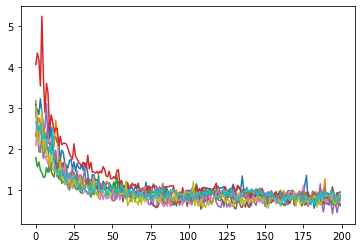

In [465]:
# x = np.array([[-2,-1,0,1,2]]).T
# y = np.array([[1,-1,1,1,-1]]).T
m_arr = [5,15,44,50]
n_arr = [5,10]
m = 5
n = 10
np.random.seed(0)
x = np.random.randn(n,3)
y = np.array([[1 if np.random.randint(0,1) == 1 else -1 for i in range(n)]]).T
num_trials = 10
net = nnet(x,y,hidden=m)
for i in range(num_trials):
    print('Trial',i+1)
    net.gradient_descent()
    net.reset()
net.plot()

In [280]:
optimal = convex_problem(x,y)
approx_optimal = convex_problem(x,y,approx=True)

Generating Diag Matrices...
Generating Convex Minimization Problem...
   Iteration 10 / 92
   Iteration 20 / 92
   Iteration 30 / 92
   Iteration 40 / 92
   Iteration 50 / 92
   Iteration 60 / 92
   Iteration 70 / 92
   Iteration 80 / 92
   Iteration 90 / 92
Solving Minimization Problem...


C:\Users\panda\AppData\Local\Temp/ipykernel_13548/1618391969.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  A = np.concatenate([np.zeros([1,dim]),data[[entry]]])



The optimal value is 0.6584145548541278
A solution x is
[[-1.58280114e-13 -5.00398044e-14 -3.37501960e-14  7.39327531e-14
  -7.56508541e-14  7.92646834e-14 -1.17484816e-13  4.73284030e-14
  -3.39597509e-14  1.09957488e-14 -7.17614722e-14 -6.25723397e-14
   6.04700336e-14  4.28732474e-14 -4.83101588e-13 -2.31701739e-13
   1.73668202e-13  2.82838766e-13 -4.06479031e-13  2.80812140e-13
  -5.27187615e-13 -4.97326647e-13  2.78222245e-13  2.81389259e-13
  -3.10935572e-13  2.36793045e-13 -1.71540577e-13  3.69537700e-14
  -3.34459987e-13 -3.38445731e-13  2.73308533e-13  2.52536395e-13
  -2.07509222e-13 -1.64478903e-14  1.43104538e-14  2.06079290e-13
  -1.22516090e-13  4.58603446e-14  6.15580775e-14 -5.06749423e-14
  -6.39961014e-14  3.13907709e-14 -3.06444354e-13  2.75703898e-13
  -2.35325970e-13  9.06187372e-14 -3.58584050e-14 -2.74742759e-14
   3.67888867e-14 -5.32130517e-14 -2.26972024e-13  7.15019721e-14
  -1.59492291e-13  3.84380506e-14 -4.50440962e-14  2.09497565e-14
  -4.74448349e-14 -

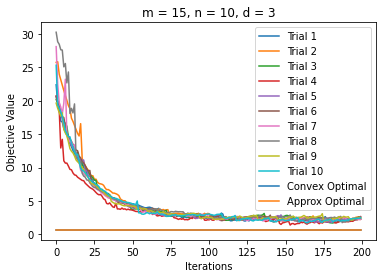

In [281]:
legend = []
num = 1
for trial in net.trial_arr:
    plt.plot(trial)
    legend.append('Trial {}'.format(num))
    num += 1
legend.append('Convex Optimal')
legend.append('Approx Optimal')
plt.plot(np.ones(net.max_iters)*optimal)
plt.plot(np.ones(net.max_iters)*approx_optimal)
plt.legend(legend)
plt.title('m = {}, n = {}, d = {}'.format(net.m,x.shape[0],x.shape[1]))
plt.xlabel('Iterations')
plt.ylabel('Objective Value')
plt.show()

In [459]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def preprocess(file):
    np.random.seed(14)
    label_1, label_2 = 1,2
    raw_cifar = unpickle(file)
    raw_labels = np.array(raw_cifar[b'labels'])
    raw_data = raw_cifar[b'data']

    #Sample ~5% of data
    sample_ind = np.array([1 if np.random.randint(100) <= 5 else 0 for i in range(raw_data.shape[0])])
    sample_data = raw_data[sample_ind == 1]
    sample_labels = raw_labels[sample_ind == 1]

    X_raw = sample_data[(sample_labels == label_1) | (sample_labels == label_2)]

    #Convert to gray
    X_img_gray = X_raw.reshape(X_raw.shape[0],3,32,32)
    R,G,B = X_img_gray[:,0,:,:], X_img_gray[:,1,:,:], X_img_gray[:,2,:,:]
    X_img_gray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    X_gray = X_img_gray.reshape(X_raw.shape[0],int(X_raw.shape[1]/3))
    #normalize data
    X_norm = X_gray/1000#np.array([np.linalg.norm(X_gray,axis=1)]).T
    print(X_norm.shape)
    pca = PCA(n_components = 100)
    X = pca.fit_transform(X_norm)

    y_raw = np.array([sample_labels[(sample_labels == label_1) | (sample_labels == label_2)]]).T
    y = np.array([[1 if label == label_1 else -1 for label in y_raw]]).T
    
    return X,y

In [460]:
file = 'CIFAR-10/data_batch_1'
test_file = 'CIFAR-10/test_batch'
X,y = preprocess(file)
X_test,y_test = preprocess(test_file)

(103, 1024)
(102, 1024)


Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


C:\Users\panda\AppData\Local\Temp/ipykernel_13548/209218911.py:113: RuntimeWarning: invalid value encountered in true_divide
  label_pred = y_pred/np.abs(y_pred)


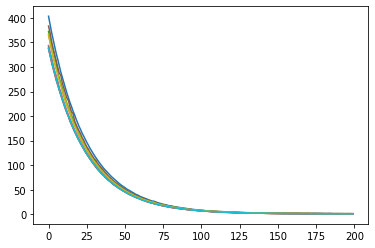

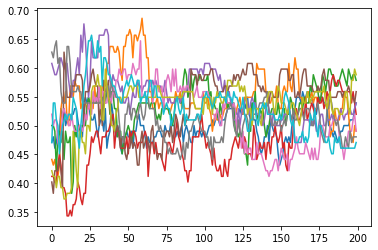

In [461]:
num_trials = 10
net = nnet(X,y,test_data = (X_test,y_test),hidden=12)
for i in range(num_trials):
    print('Trial',i+1)
    net.gradient_descent()
    net.reset()
net.plot()

In [463]:
cifar_optimal = convex_problem(X,y,approx=True)

Generating Diag Matrices...
Generating Convex Minimization Problem...
   Iteration 10 / 100
   Iteration 20 / 100
   Iteration 30 / 100
   Iteration 40 / 100
   Iteration 50 / 100
   Iteration 60 / 100
   Iteration 70 / 100
   Iteration 80 / 100
   Iteration 90 / 100
   Iteration 100 / 100
Solving Minimization Problem...

The optimal value is 2.7724983096667413
A solution x is
[[ 5.91438125e-12  4.37942337e-12  8.55881271e-11 ... -1.40386702e-01
  -5.06065948e-12 -1.11374372e-01]
 [-1.83966128e-11 -2.37802042e-12 -2.61985899e-11 ...  4.48791491e-02
   3.14014794e-12  2.60092562e-01]
 [ 2.58092893e-13 -2.16903811e-12  5.43565724e-11 ... -1.04988434e-01
   2.73193399e-12  2.49582121e-02]
 ...
 [ 5.22906000e-12  2.93330395e-12  2.43104011e-11 ...  2.42077465e-02
   2.24919907e-13  4.54984958e-02]
 [-2.02453393e-12 -6.98330646e-13 -4.77947385e-12 ... -7.90131642e-03
  -3.04374615e-14  1.09613562e-03]
 [-5.76435845e-12 -2.48016714e-12 -1.65333853e-11 ... -7.62263458e-03
  -7.80010853e-13 -5

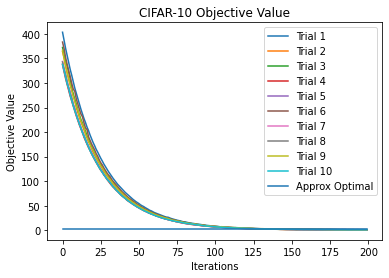

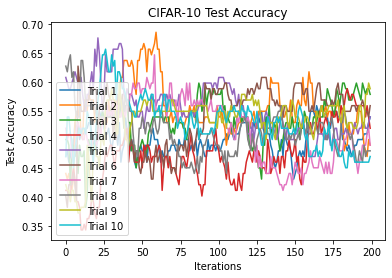

In [464]:
legend = []
num = 1
for trial in net.trial_arr:
    plt.plot(trial)
    legend.append('Trial {}'.format(num))
    num += 1
legend.append('Approx Optimal')
plt.plot(np.ones(net.max_iters)*cifar_optimal)
plt.legend(legend)
plt.title('CIFAR-10 Objective Value')
plt.ylabel('Objective Value')
plt.xlabel('Iterations')
plt.show()

legend = []
num = 1
for test in net.trial_acc_arr:
    plt.plot(test)
    legend.append('Trial {}'.format(num))
    num += 1
#plt.plot(np.ones(net.max_iters)*cifar_optimal)
plt.legend(legend)
plt.title('CIFAR-10 Test Accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Iterations')
plt.show()

In [370]:
np.random.seed(0)

num_trials = 10
n_arr = [10,100,500]
prob_arr = []
for n in n_arr:
    for i in range(2,100):
        m = i
        nan_count = 0
        if m%10 == 0:
            print('m =',m)
        for i in range(num_trials):
            x = np.random.randn(n,3)
            y = np.array([[1 if np.random.randint(0,1) == 1 else -1 for i in range(n)]]).T
            net = nnet(x,y,hidden=m)
            net.gradient_descent()
            if np.isnan(np.array(net.loss_arr)).any():
                nan_count += 1
        prob_arr.append(nan_count/num_trials)  

m = 10


C:\Users\panda\AppData\Local\Temp/ipykernel_13548/209218911.py:71: RuntimeWarning: overflow encountered in matmul
  layer_2 = relu @ self.w2 #+ self.b2
C:\Users\panda\AppData\Local\Temp/ipykernel_13548/209218911.py:47: RuntimeWarning: overflow encountered in square
  return 0.5*np.linalg.norm(y_pred-self.y)**2 + self.beta/2 * np.sum(np.linalg.norm(self.w1,axis = 0)**2 + self.w2**2)
C:\Users\panda\AppData\Local\Temp/ipykernel_13548/209218911.py:50: RuntimeWarning: overflow encountered in matmul
  d_w1_left = self.X.T @ (((self.ReLU(self.X @ self.w1) @ self.w2 - self.y) @ self.w2.T) \
C:\Users\panda\AppData\Local\Temp/ipykernel_13548/209218911.py:50: RuntimeWarning: invalid value encountered in multiply
  d_w1_left = self.X.T @ (((self.ReLU(self.X @ self.w1) @ self.w2 - self.y) @ self.w2.T) \
C:\Users\panda\AppData\Local\Temp/ipykernel_13548/209218911.py:55: RuntimeWarning: overflow encountered in matmul
  d_w2_left = self.ReLU(self.X @ self.w1).T @ ((self.ReLU(self.X @ self.w1) @ self.w

m = 20


C:\Users\panda\AppData\Local\Temp/ipykernel_13548/209218911.py:69: RuntimeWarning: invalid value encountered in matmul
  layer_1 = X @ self.w1 #+ self.b1
C:\Users\panda\AppData\Local\Temp/ipykernel_13548/209218911.py:51: RuntimeWarning: invalid value encountered in matmul
  * self.d_ReLU(self.X @ self.w1))


m = 30
m = 40
m = 50
m = 60


C:\Users\panda\AppData\Local\Temp/ipykernel_13548/209218911.py:82: RuntimeWarning: invalid value encountered in subtract
  self.w2 -= self.lr * d_w2


m = 70


C:\Users\panda\AppData\Local\Temp/ipykernel_13548/209218911.py:47: RuntimeWarning: overflow encountered in add
  return 0.5*np.linalg.norm(y_pred-self.y)**2 + self.beta/2 * np.sum(np.linalg.norm(self.w1,axis = 0)**2 + self.w2**2)


m = 80
m = 90
m = 10
m = 20
m = 30
m = 40
m = 50
m = 60
m = 70
m = 80
m = 90
m = 10
m = 20
m = 30
m = 40
m = 50
m = 60
m = 70
m = 80
m = 90


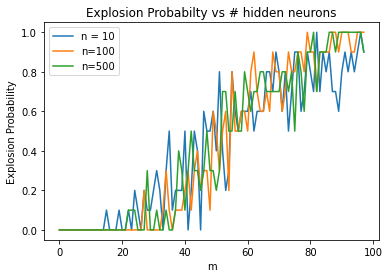

In [376]:
plt.plot(prob_arr[:98])
plt.plot(prob_arr[98:196])
plt.plot(prob_arr[196:])
plt.ylabel('Explosion Probability')
plt.xlabel('m')
plt.title('Explosion Probabilty vs # hidden neurons')
plt.legend(['n = 10','n=100','n=500'])
plt.show()